In [1]:
# imports and defaults
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import prettyplot as pp
import cn_derivations as cn
import numpy as np
import os
import data_parser as dp
import math
import mpmath
from timeit import default_timer as timer
import r_function_port as rfp

mpmath.dps = 30
mpmath.pretty = True

pd.options.display.max_rows = 10
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
os.getcwd()

# Time zone adjustment
import matplotlib
matplotlib.rcParams['timezone'] = 'CET'

In [2]:
"""Data overview"""
filename = "2019-05-24"
station = "schiessstand"

sdf = dp.scintillometer_parse(filename)

In [3]:
import importlib
importlib.reload(cn)
computed_data = cn.data_processor(filename, station)
cdf = computed_data["computed"]
z_eff = {"stable": computed_data["z_eff_stable"], "unstable": computed_data["z_eff_unstable"]}

Mean path height: 31.83766108843537m
Effective path height, stable: 31.34392287277671m
Effective path height, unstable: 25.62897860987237m

Please enter the time at which stable switches to unstable: 0712


/home/nick/PycharmProjects/Feldkurs/ss19-feldkurs/Pycode/cn_derivations.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  g / dataframe["temperature"]) ** (1 / 2)


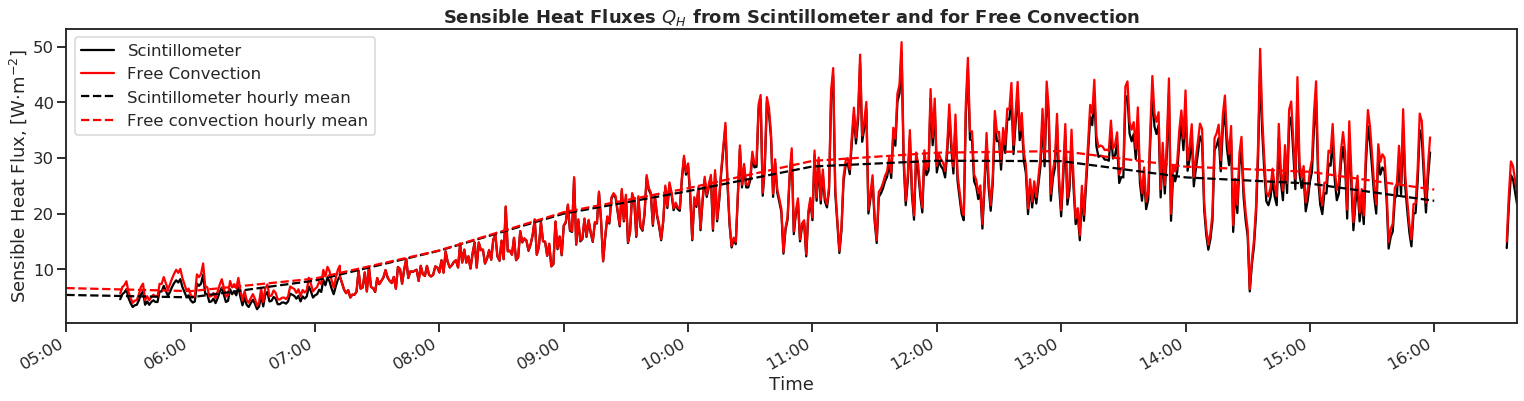

In [4]:
fig = pp.plot_free_convection(sdf, cdf)
plt.show()

In [6]:
"""Ward's iteration"""
# Takes 100s or so to run
cdf_backup = cdf  # in case of later testing
switch_time = "0712"
cdf = rfp.ward_method(cdf, z_eff, switch_time)

/home/nick/miniconda3/envs/py3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/home/nick/PycharmProjects/Feldkurs/ss19-feldkurs/Pycode/r_function_port.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  "obukhov"].loc[index])
/home/nick/PycharmProjects/Feldkurs/ss19-feldkurs/Pycode/r_function_port.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dataframe["CT2"].loc[index] * (zm_bl

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [8]:
cdf

,Cn2,temperature,pressure,windspeed,CT2,Q_0,rho_air,H_free,obukhov,shf,u_star,theta_star,obukhov_diff,shf_diff
Time,,,,,,,,,,,,,,
2019-05-24 05:26:00+02:00,1.911500e-16,281.494682,1018.700000,0.179078,0.000192,0.004449,1.260720,5.630801,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>
2019-05-24 05:27:00+02:00,2.447200e-16,281.489683,1018.700000,0.177690,0.000246,0.005354,1.260742,6.776883,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>
2019-05-24 05:28:00+02:00,2.616500e-16,281.484685,1018.700000,0.176301,0.000263,0.005629,1.260765,7.125361,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>
2019-05-24 05:29:00+02:00,2.964500e-16,281.479686,1018.700000,0.174913,0.000298,0.006181,1.260787,7.824712,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>
2019-05-24 05:30:00+02:00,2.020200e-16,281.474688,1018.700000,0.173524,0.000203,0.004636,1.260809,5.868660,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24 16:36:00+02:00,1.493400e-15,296.096041,1010.353959,1.832785,0.001867,0.019528,1.188730,23.306633,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>
2019-05-24 16:37:00+02:00,2.033100e-15,296.107710,1010.342290,1.857792,0.002543,0.024615,1.188670,29.376135,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>
2019-05-24 16:38:00+02:00,1.957600e-15,296.119380,1010.330620,1.882799,0.002449,0.023929,1.188609,28.555959,-100,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>,<class 'float'>


In [7]:
import importlib
importlib.reload(pp)
fig = pp.plot_generic(cdf, "shf")
plt.show()

TypeError: float() argument must be a string or a number, not 'type'

In [ ]:
fig = pp.plot_generic(cdf, "l_ob")
plt.show()

In [ ]:
fig = plt.figure(figsize=(26, 6))
sdf["H_convection"].plot(color="black", label="Scintillometer")
cdf["shf"].plot(color="red", label="Iterated Flux")

plt.legend(loc="upper left")
plt.title(
    r"Sensible Heat Fluxes $Q_{H}$ from Scintillometer and from Iteration",
    fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes

In [ ]:
"""Data overview"""
filename = "2018-05-06"
station = "schiessstand"

sdf_old = dp.scintillometer_parse(filename)
computed_data_old = cn.data_processor(filename, station)
cdf_old = computed_data_old["computed"]
z_eff_old = computed_data_old["effective_height"]

In [ ]:
"""Ward's iteration"""
# Takes 100s or so to run
cdf_old_backup = cdf_old.copy()  # in case of later testing
cdf_old = rfp.ward_method(cdf_old, z_eff)

In [ ]:
fig = pp.plot_generic(cdf_old_backup, "H_free")
plt.show()

In [ ]:
fig = plt.figure(figsize=(26, 6))
sdf_old["H_convection"].plot(color="black", label="Scintillometer")
cdf_old["shf"].plot(color="red", label="Iterated Flux")

plt.legend(loc="upper left")
plt.title(
    r"Sensible Heat Fluxes $Q_{H}$ from Scintillometer and from Iteration",
    fontweight="bold")
plt.xlabel("Time")
plt.ylabel("Sensible Heat Flux, [W$\cdot$m$^{-2}$]")
ax = plt.gca()
ax.xaxis.set_major_formatter(
    dates.DateFormatter('%H:%M'))  # hours and minutes